In [1]:
# --- Imports and Setup ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import warnings
warnings.filterwarnings("ignore")

# --- 1. Configuration ---
STOCK_TICKER = 'HINDUNILVR.NS'
START_DATE = '2015-01-01'
END_DATE = '2025-07-20'

# --- 2. Data Collection ---
print(f"Fetching data for {STOCK_TICKER}...")
df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
if df.empty:
    raise ValueError("Data fetch failed. Check ticker or internet connection.")

df_close = df[['Close']].copy()
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close.asfreq('D')
df_close.ffill(inplace=True)
df_close.bfill(inplace=True)

Fetching data for HINDUNILVR.NS...


[*********************100%***********************]  1 of 1 completed


In [2]:
df_close.head()

Price,Close
Ticker,HINDUNILVR.NS
Date,
2015-01-01,640.709534
2015-01-02,638.597900
2015-01-03,638.597900
2015-01-04,638.597900
2015-01-05,642.272583


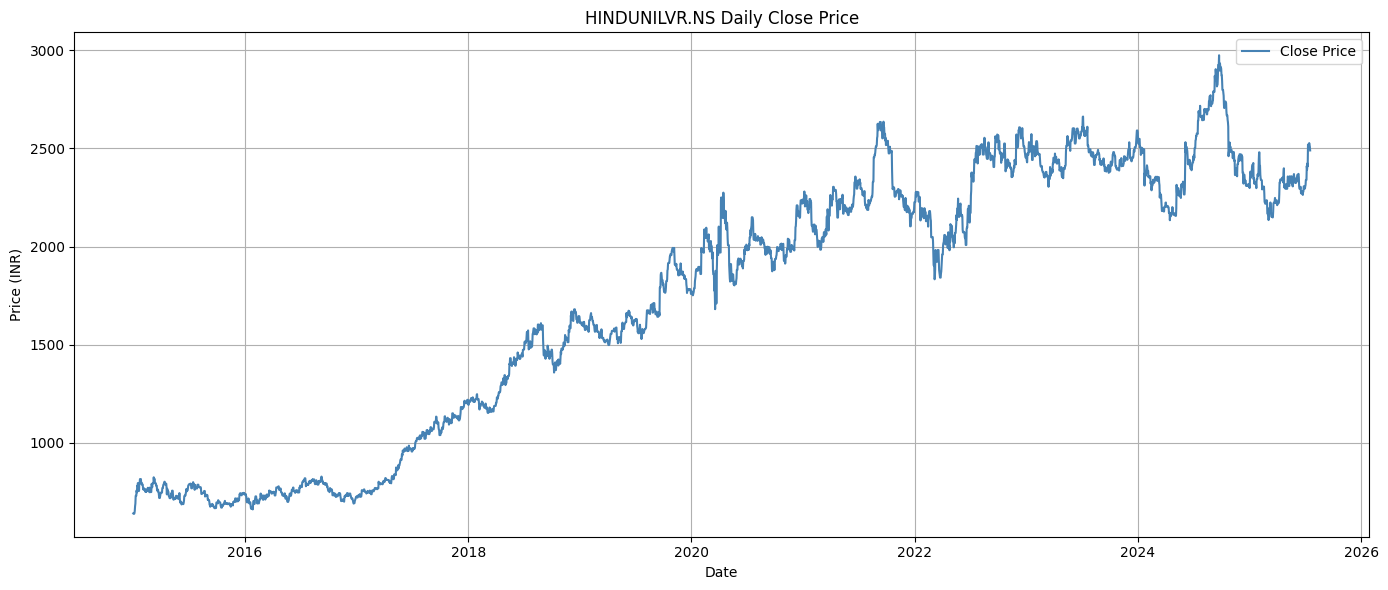

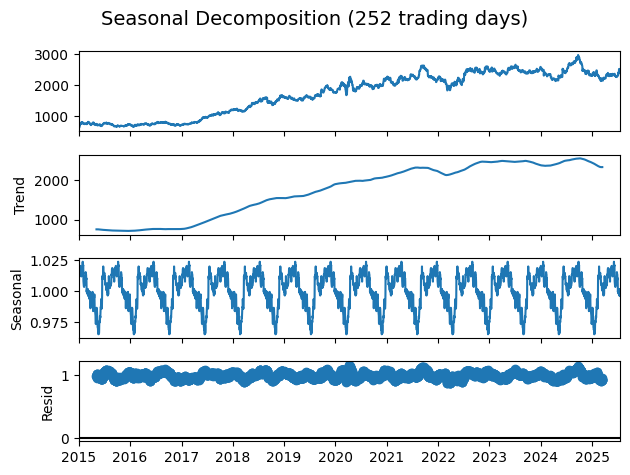

In [3]:
# --- 3. EDA: Visuals & Decomposition ---
plt.figure(figsize=(14, 6))
plt.plot(df_close['Close'], label='Close Price', color='steelblue')
plt.title(f'{STOCK_TICKER} Daily Close Price')
plt.xlabel('Date'); plt.ylabel('Price (INR)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Seasonal Decomposition
try:
    decomposition = seasonal_decompose(df_close['Close'], model='multiplicative', period=252)
    decomposition.plot().suptitle('Seasonal Decomposition (252 trading days)', fontsize=14)
    plt.tight_layout()
    plt.show()
except:
    print("Decomposition failed — likely due to insufficient data or NaNs.")


ADF Test - Original Close Price
ADF Statistic: -1.2252, p-value: 0.6627
Non-Stationary

ADF Test - 1st Differenced
ADF Statistic: -23.3805, p-value: 0.0000
Stationary


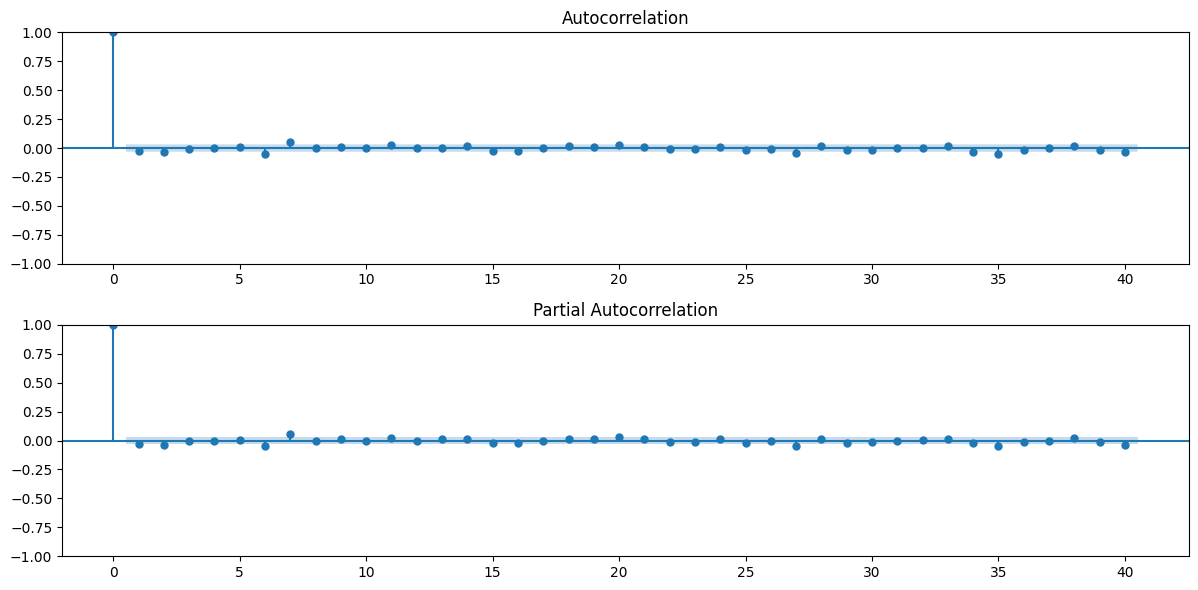

In [4]:
# --- 4. Stationarity Check ---
def adf_test(series, name='Series'):
    print(f"\nADF Test - {name}")
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

adf_test(df_close['Close'], 'Original Close Price')
df_diff1 = df_close['Close'].diff().dropna()
adf_test(df_diff1, '1st Differenced')

# ACF & PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df_diff1, ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(df_diff1, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()


In [5]:
# --- 5. Train-Test Split ---
train_size = int(len(df_close) * 0.8)
train_data, test_data = df_close.iloc[:train_size], df_close.iloc[train_size:]

# --- 6. Grid Search for Best ARIMA(p,d,q) ---
print("\nRunning ARIMA Grid Search...")
p = range(0, 3)
d = [1]  # Based on ADF
q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

best_rmse = float('inf')
best_order = None

for order in pdq_combinations:
    try:
        model = ARIMA(train_data['Close'], order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
        print(f"ARIMA{order} → RMSE: {rmse:.2f}")
    except:
        continue

if not best_order:
    raise ValueError("No suitable ARIMA model found.")

print(f"\n✅ Best ARIMA Order: {best_order} with RMSE: {best_rmse:.2f}")


Running ARIMA Grid Search...
ARIMA(0, 1, 0) → RMSE: 216.75
ARIMA(0, 1, 1) → RMSE: 217.18
ARIMA(0, 1, 2) → RMSE: 217.61
ARIMA(1, 1, 0) → RMSE: 217.13
ARIMA(1, 1, 1) → RMSE: 218.05
ARIMA(1, 1, 2) → RMSE: 217.78
ARIMA(2, 1, 0) → RMSE: 217.48
ARIMA(2, 1, 1) → RMSE: 217.71
ARIMA(2, 1, 2) → RMSE: 216.65

✅ Best ARIMA Order: (2, 1, 2) with RMSE: 216.65



Training Final ARIMA(2, 1, 2) Model...

--- Model Evaluation ---
Test RMSE: 216.65
Test MAE : 188.89


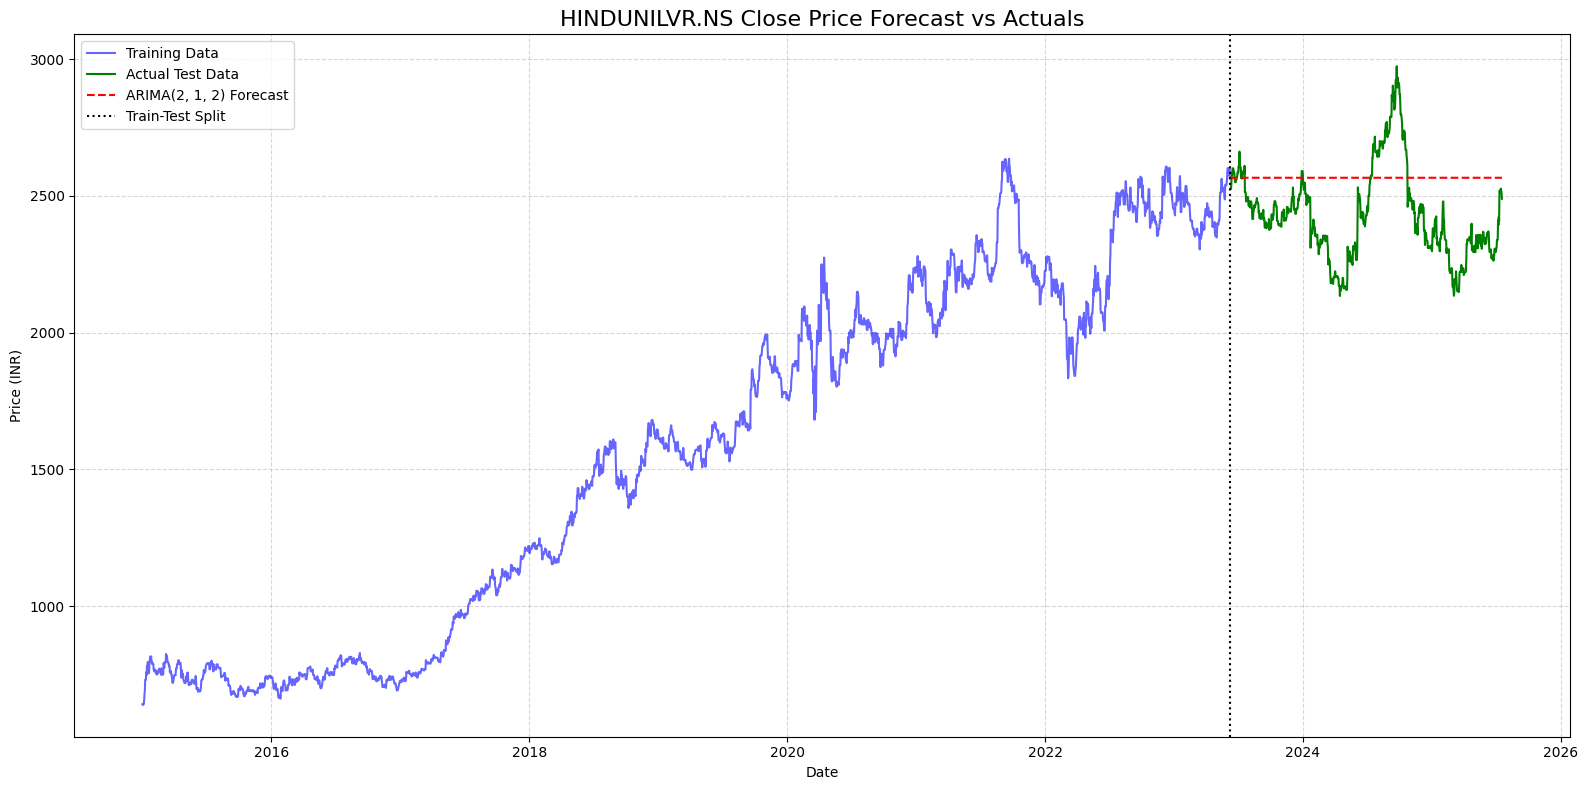

In [6]:
# --- 7. Final Model Training ---
print(f"\nTraining Final ARIMA{best_order} Model...")
final_model = ARIMA(train_data['Close'], order=best_order)
final_model_fit = final_model.fit()

# --- 8. Forecasting ---
forecast_steps = len(test_data)
forecast = final_model_fit.forecast(steps=forecast_steps)
predictions_df = pd.DataFrame({'Forecast': forecast}, index=test_data.index)

# --- 9. Evaluation ---
rmse = np.sqrt(mean_squared_error(test_data['Close'], predictions_df['Forecast']))
mae = mean_absolute_error(test_data['Close'], predictions_df['Forecast'])

print(f"\n--- Model Evaluation ---")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE : {mae:.2f}")

# --- 10. Plot Actual vs. Forecast ---
plt.figure(figsize=(16, 8))
plt.plot(train_data['Close'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test_data['Close'], label='Actual Test Data', color='green')
plt.plot(predictions_df['Forecast'], label=f'ARIMA{best_order} Forecast', color='red', linestyle='--')
plt.axvline(x=test_data.index[0], color='black', linestyle=':', label='Train-Test Split')
plt.title(f'{STOCK_TICKER} Close Price Forecast vs Actuals', fontsize=16)
plt.xlabel('Date'); plt.ylabel('Price (INR)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()


In [7]:
import warnings
import itertools
import numpy as np
import statsmodels.api as sm

# Fix ARIMA base
fixed_order = (1, 1, 1)
seasonal_grid=[7,15,30]

# Smart seasonal grid (instead of 27 combos)
P = [0, 1]
D = [0, 1]
Q = [0, 1]
seasonal_pdq = [(p, d, q, s) for p, d, q,s in itertools.product(P, D, Q,seasonal_grid)]

lowest_aic = np.inf
best_seasonal_param = None

warnings.filterwarnings("ignore")
print("Optimized SARIMA Grid Search Started...\n")

for seasonal_order in seasonal_pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(train_data['Close'],
                                          order=fixed_order,
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < lowest_aic:
            lowest_aic = results.aic
            best_seasonal_param = seasonal_order
    except Exception as e:
        print(f"Failed for seasonal_order={seasonal_order} | Error: {e}")
        continue

print(f"\nBest SARIMA Model: Order={fixed_order}, Seasonal Order={best_seasonal_param}, AIC={lowest_aic:.2f}")


Optimized SARIMA Grid Search Started...


Best SARIMA Model: Order=(1, 1, 1), Seasonal Order=(1, 1, 1, 30), AIC=26909.97


In [8]:
# Fit best model
model = sm.tsa.statespace.SARIMAX(train_data['Close'],
                                  order=fixed_order,
                                  seasonal_order=best_seasonal_param,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
sarima_result = model.fit()

# Summary
print(sarima_result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                      HINDUNILVR.NS   No. Observations:                 3081
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood              -13449.986
Date:                            Fri, 01 Aug 2025   AIC                          26909.973
Time:                                    23:37:28   BIC                          26940.035
Sample:                                01-01-2015   HQIC                         26920.783
                                     - 06-08-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5870      0.173      3.400      0.001       0.249       0.925
ma.L1         -0.6248      0.167   

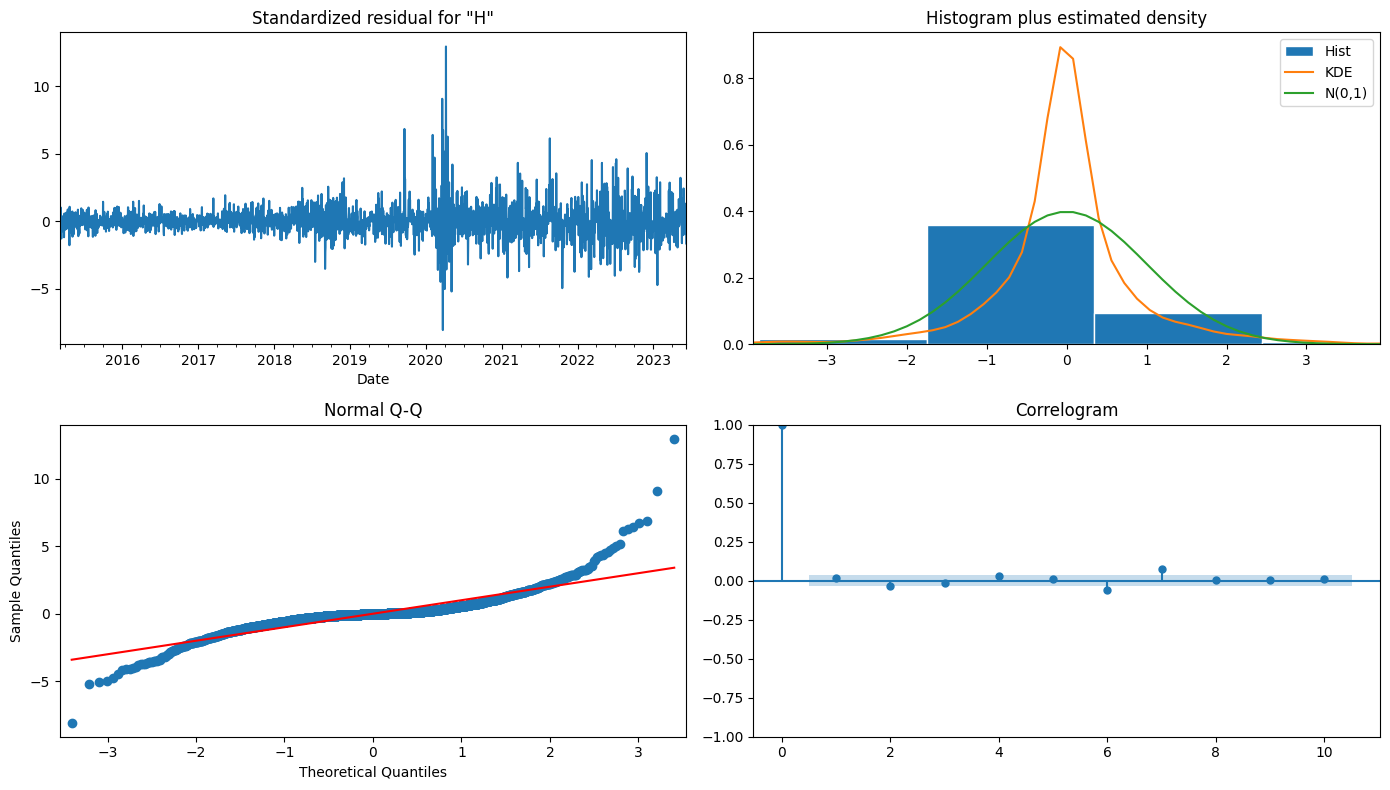

In [9]:
sarima_result.plot_diagnostics(figsize=(14, 8))
plt.tight_layout()
plt.show()

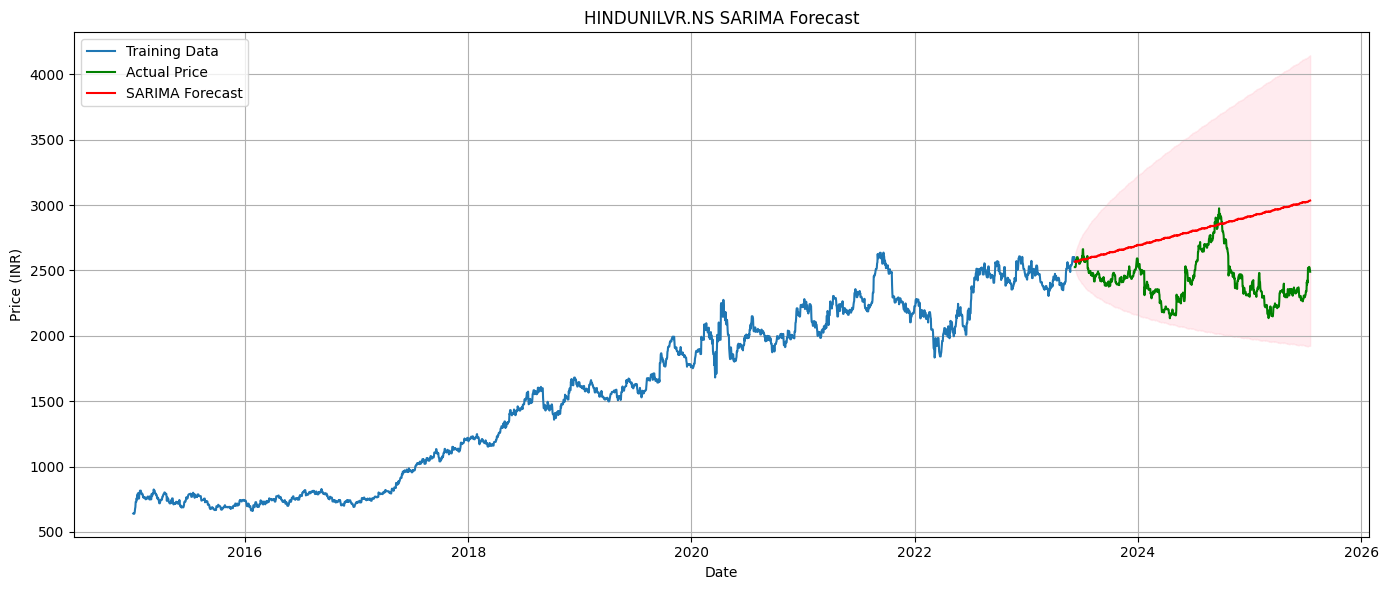

In [10]:
forecast_steps = len(test_data)
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['Close'], label='Training Data')
plt.plot(test_data.index, test_data['Close'], label='Actual Price', color='green')
plt.plot(test_data.index, forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date'); plt.ylabel('Price (INR)')
plt.title(f'{STOCK_TICKER} SARIMA Forecast')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [11]:
y_pred = forecast.predicted_mean
y_true = test_data['Close']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 439.40
MAE: 374.63
